In [4]:
import geopandas as gpd # GeoPandas(지오판다스)
import shutil # shutil(shell utility, 쉘 유틸리티)
import glob # glob(글로브)

In [1]:
import pandas as pd

# SPECIES_NAME = 'Ursus_arctos_Linnaeus'
# SPECIES_NAME = 'Theropithecus_gelada'
# SPECIES_NAME = 'Camelus_dromedarius_Linnaeus'
SPECIES_NAME = 'Camel'
train_vec = pd.read_csv(f"../../data/{SPECIES_NAME}.csv")
train_vec.head()

,CLASS,bclim1,bclim10,bclim11,bclim12,bclim13,bclim14,bclim15,bclim16,bclim17,bclim18,bclim19,bclim2,bclim3,bclim4,bclim5,bclim6,bclim7,bclim8,bclim9
0,0.0,244.0,356.0,132.0,22.0,6.0,0.0,89.0,12.0,0.0,2.0,6.0,162.0,38.0,8653.0,463.0,43.0,420.0,184.0,287.0
1,1.0,192.0,205.0,171.0,656.0,122.0,5.0,78.0,331.0,15.0,287.0,19.0,105.0,70.0,1370.0,267.0,117.0,150.0,205.0,176.0
2,0.0,125.0,210.0,39.0,176.0,32.0,0.0,76.0,87.0,0.0,0.0,87.0,126.0,40.0,6707.0,298.0,-15.0,313.0,39.0,210.0
3,1.0,205.0,310.0,111.0,90.0,16.0,3.0,57.0,43.0,11.0,11.0,18.0,153.0,39.0,7578.0,418.0,31.0,387.0,200.0,310.0
4,0.0,275.0,328.0,212.0,72.0,17.0,0.0,80.0,39.0,1.0,1.0,23.0,139.0,53.0,4573.0,397.0,137.0,260.0,224.0,328.0


In [2]:
print("number of NA's: ", train_vec.isna().sum())
train_vec=train_vec.dropna()
print("number of NA's: ", train_vec.isna().sum())

number of NA's:  CLASS      0
bclim1     1
bclim10    1
bclim11    1
bclim12    1
bclim13    1
bclim14    1
bclim15    1
bclim16    1
bclim17    1
bclim18    1
bclim19    1
bclim2     1
bclim3     1
bclim4     1
bclim5     1
bclim6     1
bclim7     1
bclim8     1
bclim9     1
dtype: int64
number of NA's:  CLASS      0
bclim1     0
bclim10    0
bclim11    0
bclim12    0
bclim13    0
bclim14    0
bclim15    0
bclim16    0
bclim17    0
bclim18    0
bclim19    0
bclim2     0
bclim3     0
bclim4     0
bclim5     0
bclim6     0
bclim7     0
bclim8     0
bclim9     0
dtype: int64


## 섹션 2 | 종 적합성(Species suitability) 매핑

In [5]:
# 래스터 특징
raster_features = sorted(glob.glob(
    f'../../data/{SPECIES_NAME}/bclim*.asc'))
print(raster_features)

['../../data/Camel\\bclim1.asc', '../../data/Camel\\bclim10.asc', '../../data/Camel\\bclim11.asc', '../../data/Camel\\bclim12.asc', '../../data/Camel\\bclim13.asc', '../../data/Camel\\bclim14.asc', '../../data/Camel\\bclim15.asc', '../../data/Camel\\bclim16.asc', '../../data/Camel\\bclim17.asc', '../../data/Camel\\bclim18.asc', '../../data/Camel\\bclim19.asc', '../../data/Camel\\bclim2.asc', '../../data/Camel\\bclim3.asc', '../../data/Camel\\bclim4.asc', '../../data/Camel\\bclim5.asc', '../../data/Camel\\bclim6.asc', '../../data/Camel\\bclim7.asc', '../../data/Camel\\bclim8.asc', '../../data/Camel\\bclim9.asc']


In [6]:
# 래스터 특징 수 확인
print(len(raster_features), '개 래스터 특징')

19 개 래스터 특징


In [7]:
# pyimpute 모듈
from pyimpute import load_targets

In [8]:
train_xs, train_y = train_vec.iloc[:,1:20].values, train_vec.iloc[:,0].values # 훈련 데이터 로드
target_xs, raster_info = load_targets(raster_features) # scikit-learn용 데이터 구조로 래스터 특징 로드
train_xs.shape, train_y.shape # 관측치 크기와 일치하는지 shape 확인

((947, 19), (947,))

In [9]:
# ML 분류기 로드
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm, metrics


In [10]:
# ML 분류기 딕셔너리: 이름, (모델)
CLASS_MAP = {
    'RF': (RandomForestClassifier()),
    'ET': (ExtraTreesClassifier()),
    'XGB': (XGBClassifier()),
    'LGBM': (LGBMClassifier()),
    }

In [11]:
# pyimpute, sklearn 로드
from pyimpute import impute
from sklearn import model_selection

In [12]:
# 모델 피팅 및 공간 예측(model fitting and spatial range prediction)
SAVE_PATH = f'{SPECIES_NAME}_prediction/'

import os
if not os.path.exists(SAVE_PATH):
      os.mkdir(SAVE_PATH)

for name, (model) in CLASS_MAP.items():
    # 교차 검증(cross validation)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold 교차 검증 정확도: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # 공간 예측(spatial prediction)
    model.fit(train_xs, train_y)
    if not os.path.exists(SAVE_PATH + name + '-IMAGES'):
      os.mkdir(SAVE_PATH + name + '-IMAGES')
    impute(target_xs, model, raster_info, outdir= SAVE_PATH + name + '-IMAGES',
           class_prob=True, certainty=True)
from sklearn import svm, metrics

svm = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)


RF 5-fold 교차 검증 정확도: 84.69 (+/- 5.65)
ET 5-fold 교차 검증 정확도: 85.32 (+/- 3.99)
XGB 5-fold 교차 검증 정확도: 82.78 (+/- 5.49)
LGBM 5-fold 교차 검증 정확도: 82.79 (+/- 6.97)


In [13]:
import rasterio
distr_rf = rasterio.open( SAVE_PATH+ "RF-IMAGES/probability_1.0.tif").read(1)
distr_et = rasterio.open( SAVE_PATH+"ET-IMAGES/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open(SAVE_PATH+"XGB-IMAGES/probability_1.0.tif").read(1)
distr_lgbm =  rasterio.open(SAVE_PATH+"LGBM-IMAGES/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4

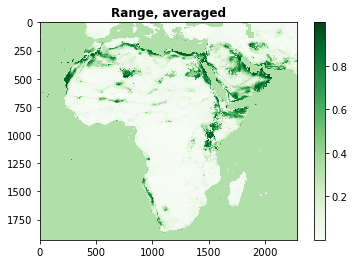

In [14]:
# 종 적합성 매핑의 평균값 가시화
from pylab import plt

def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

plotit(distr_averaged, "Range, averaged", cmap="Greens")

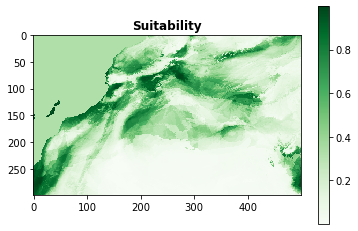

In [15]:
plotit(distr_averaged[200:500, 250:750], "Suitability", cmap="Greens")